This is a template to reconstruct holography images.

# Import libraries

Start by importing standard python libraries and the self written libraries $\mathtt{fth-reconstruction.py}$, $\mathtt{reconstruct.py}$ and $\mathtt{cameras.py}$. They have to be in the same folder or the parent directory.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import self written libraries. These have to be in the same folder or the parent directory.
import sys, os
sys.path.append('..')
import fth_reconstruction as fth
from cameras import load_greateyes, load_spe
import reconstruct as reco

In [2]:
# interactive plotting
%matplotlib notebook

# Load images 

Start by loading the images. 
1. Specify the directory of the data and the number of the positive and negative helicity image.
2. Load the data.
3. Create the difference hologram by subtracting the topography image (pos + neg) from the positive image. Set the auto_factor to *True*, otherwise the default factor of 0.5 will be used.

In [3]:
folder = '/home/gehrlinger/Documents/Beamtimes/2019-05_P04/Data/'
p = 2296
n = 2295

In [4]:
pos = load_greateyes(folder + 'holo_%04d.dat'%p)
neg = load_greateyes(folder + 'holo_%04d.dat'%n)

Loaded image /home/gehrlinger/Documents/Beamtimes/2019-05_P04/Data/holo_2296.dat
Loaded image /home/gehrlinger/Documents/Beamtimes/2019-05_P04/Data/holo_2295.dat


In [5]:
holo, factor = fth.load_both(pos, neg, True)

Auto factor = 0.4636918398235687


# Reconstruct

Reconstruct the hologramm.
1. Center the hologram.
2. Mask the beamstop.
3. Check for corsmic rays and camera defects and mask them.
4. Chose a region of interest (ROI).
5. Propagate the image and shift the phase for maximal contrast and sharpness in your ROI.

## Set center

Your hologramm is nor necessarily centered on the camera. Here you can determine the pixel coordinates of the center of the hologram and shift ist to the center of the camera image.

1. The image is plotted. Use the interactive plotting *zoom* tool (second from the right) to zoom into the image. Get the ring of the hologram centered in your field of view. You can shift the image with the *pan* tool right of *zoom*. You can use the arrows to get to the previous/next view. The *home* button (left) resets the view.
2. The limit of your FOV is read from the axes of the image. From this, the center of the hologram is determined.
3. Shift the hologram to the center.
4. The centered hologram and the original hologram are plotted next to each other to check if the centering was done correctly.

<IPython.core.display.Javascript object>


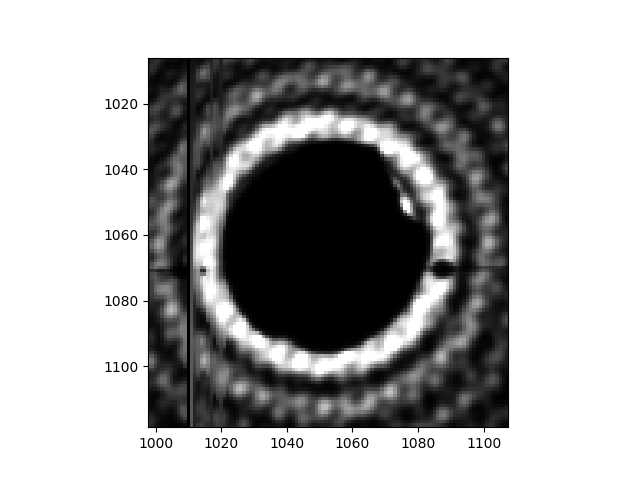

In [44]:
mi, ma = np.percentile(np.real(pos), (.01,99.99))

fig, ax = plt.subplots()
ax.imshow(np.real(pos), cmap = 'gray', vmin = mi, vmax = ma)

In [47]:
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()

center = [fth.integer(x1 + (x2 - x1)/2), fth.integer(y1 + (y2 - y1)/2)]

In [48]:
center = [1053, 1062]

[1053, 1062]

In [49]:
def integer(n):
    return np.int(np.round(n))

def set_center(image, center):
    '''this centering routine shifts the image in a cyclical fashion'''
    xdim, ydim = image.shape
    xshift = integer(xdim / 2 - center[1])
    yshift = integer(ydim / 2 - center[0])
    image_shift = np.roll(image, xshift, axis=0)
    image_shift = np.roll(image_shift, yshift, axis=1)
    print('Shifted image by %i pixels in x and %i pixels in y.'%(xshift, yshift))
    return image_shift

In [50]:
holo_c = set_center(holo, center)

Shifted image by -39 pixels in x and -30 pixels in y.


<IPython.core.display.Javascript object>


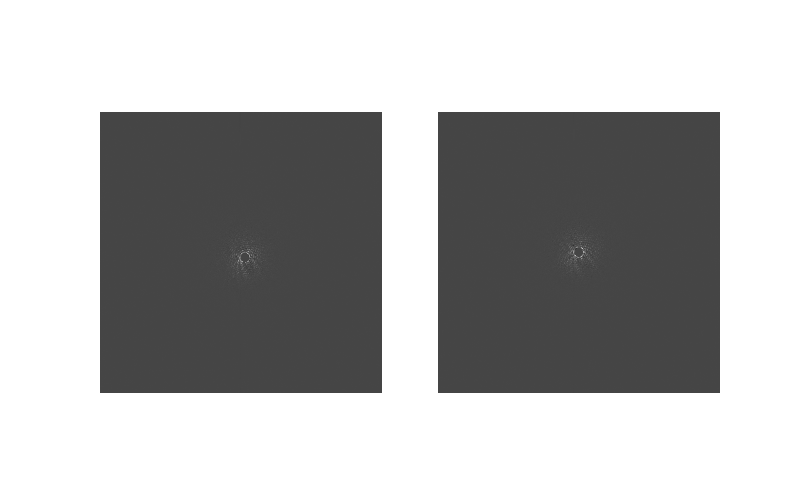

In [51]:
fig, ax = plt.subplots(1,2, figsize = (8, 5))
ax[0].imshow(np.real(holo), cmap = 'gray')
ax[0].set_axis_off()
ax[1].imshow(np.real(holo_c), cmap = 'gray')
ax[1].set_axis_off()

## Mask beamstop

Now the beamstop is masked. A circular mask is drawn with a vertain diameter and its edges are smoothed with a gauss filter.
1. Set the diameter in pixels. You can determine this by zooming into the hologram and checking the diameter of the beamstop in the hologram. Make it larger than the physical beamstop in the image so the smoothing works well.
2. The function $\mathtt{mask-beamstop(image, bs-size, sigma=10, center = None)}$ returns the masked hologram. you can set the sigma of the Gauss filter (10 is default). You can give it a center for the beamstop mask, but since you already centered the hologram, this is not necessary.
3. Plot the masked hologram to check that the beamstop is properly masked.

In [52]:
bs_diam = 80

In [53]:
holo_b = fth.mask_beamstop(holo_c, bs_diam)

<IPython.core.display.Javascript object>


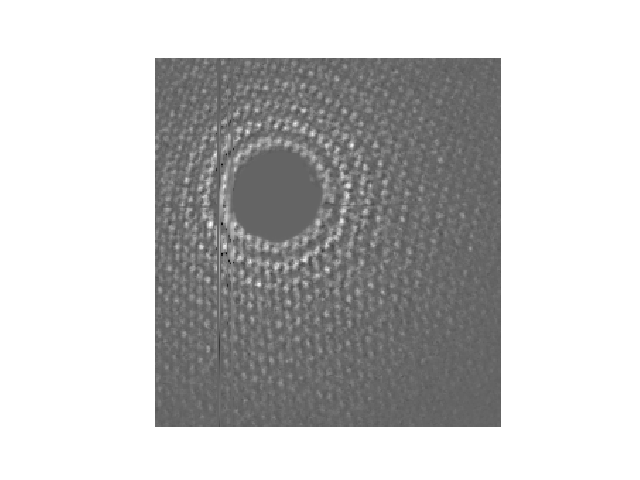

In [54]:
fig, ax = plt.subplots()
ax.imshow(np.real(holo_b), cmap = 'gray')
ax.set_axis_off()

## Remove Cosmic Rays

Cosmic rays are recorded as singular pixels with a very high count rate. Camera defects are also single or multiple pixels of high count rate. 

If they occur quite outside of center, they will be accounted for in the reconstruction and give high frequency modulations.
1. Look at the all the pixels in the masked hologram $>1000$.
2. Delete whole rows if necessary. Replace agglomerations of high pixels by values somewhere close.
3. Remove cosmic rays via the function $\mathtt{remove-cosmic-ray(holo, coordinates)}$. This function will replace the pixel of a single cosmic ray by the mean of its neighbors. If the cosmic ray extends on two pixels, use $\mathtt{remove-two(holo, x_coord, y_coord)}$ where one of the two coordinate variables should have a dimension of two.


<IPython.core.display.Javascript object>


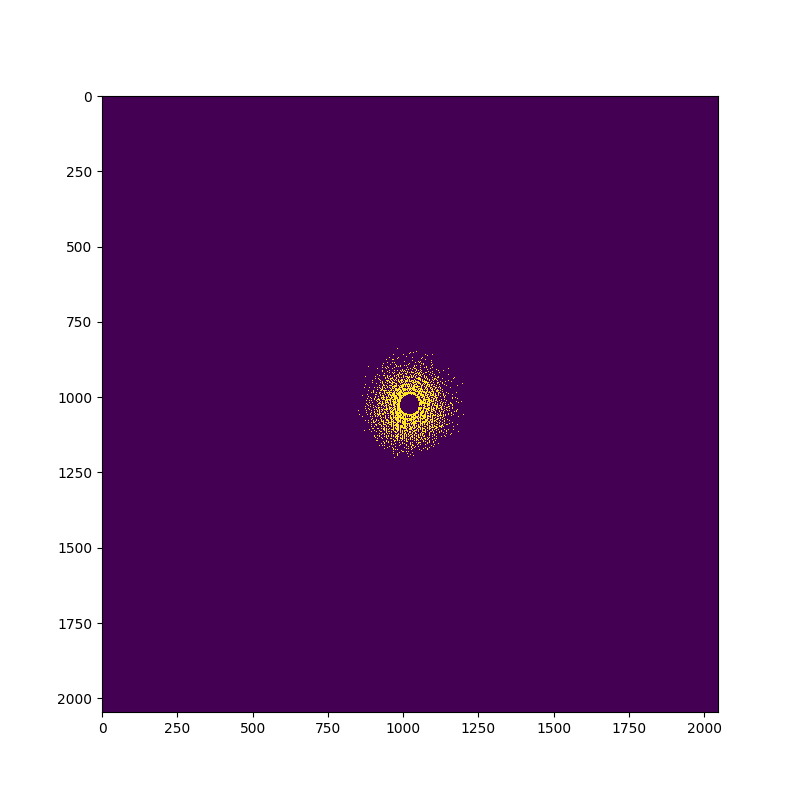

In [55]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(np.abs(holo_b)>1000)

In [ ]:
holo_b = np.delete(holo_b, 50, axis = 1)
holo_b = np.delete(holo_b, 0, axis = 0)
holo_b.shape

In [ ]:
holo_b = fth.remove_cosmic_ray(holo_b, [, 822])
# holo_b = fth.remove_cosmic_ray(holo_b, [860, 935])

## Set ROI

Set a region of interest, i.e., chose which image you want to optimize.

This is done much in the same way as the center is set:
1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

<IPython.core.display.Javascript object>


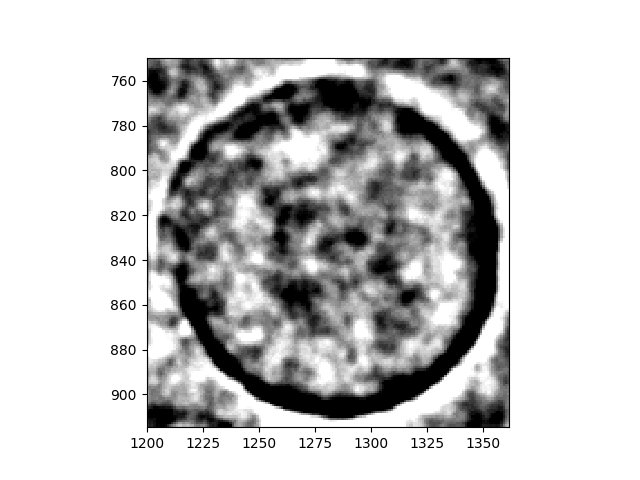

In [56]:
fig, ax = fth.plot(np.real(fth.reconstruct(holo_b)), colorbar = False)

In [57]:
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi = np.array([integer(x1), integer(x2), integer(y1), integer(y2)]) #xstart, xstop, ystart, ystop

## Propagate and Phase Shift

Propagte your FOV and shift the phase to have all magnetic signal in the real image. This is done via ipython widget sliders (https://ipywidgets.readthedocs.io/en/latest/).

<IPython.core.display.Javascript object>


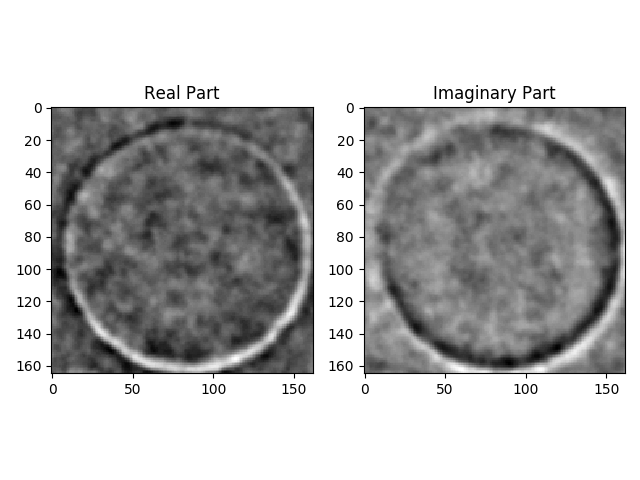

interactive(children=(FloatSlider(value=0.0, description='propagation[um]', layout=Layout(width='90%'), max=10…

Button(description='Finished', style=ButtonStyle())

In [72]:
slider_prop, slider_phase, button = reco.propagate(holo_b, roi)

In [73]:
prop_dist=slider_prop.value

phase = slider_phase.value

# Save Reconstruction Data

Save the reconstructed data in a hdf5 file.

In [64]:
folder_save = './test/'

if not(os.path.exists(folder_save)):
    print("Creating folder " + folder_save)
    os.mkdir(folder_save)

Creating folder ./test/


In [76]:
recon = fth.reconstruct(fth.propagate(holo_b, prop_dist*1e-6)*np.exp(1j*phase))[roi[2]:roi[3], roi[0]:roi[1]]

Propagation distance: 2.36um


<IPython.core.display.Javascript object>


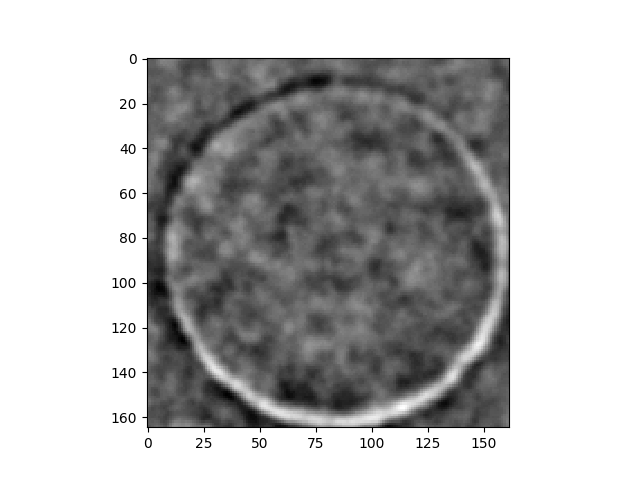

In [77]:
fig, ax = plt.subplots()
ax.imshow(np.real(recon), cmap = 'gray')

In [94]:
drecon = pd.DataFrame.from_records(recon, index =[ i for i in range(recon.shape[0])], 
                                   columns = [i for i in range(recon.shape[1])])

In [95]:
drecon

IndexError: list index out of range

IndexError: list index out of range

In [ ]:
reco.save_parameters(holo, center, prop_dist, phase, roi, folder_save, [p,n], bs_diam, propagate=True)